In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import numpy as np
import os

In [63]:
os.environ['KAGGLE_USERNAME']="USUARIO"
os.environ['KAGGLE_KEY']="API_KEY"

In [64]:
# descargar dataset de kaggle en la ruta 'datasets/
!kaggle datasets download -d splcher/animefacedataset -p datasets

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
!unzip datasets/animefacedataset.zip -d datasets/

Archive:  datasets/animefacedataset.zip
replace datasets/images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [66]:
anime_directorio = "/content/datasets/images"

In [67]:
imagenes_entrenamiento = tf.keras.utils.image_dataset_from_directory(
    anime_directorio, label_mode=None, image_size=(64, 64), batch_size=256 # tamaño del batch, actualizado de 32
)

Found 63565 files.


## ***Visualización***
Siempre me gusta visualizar los datos de entrenamiento para hacerme una idea de cómo son.

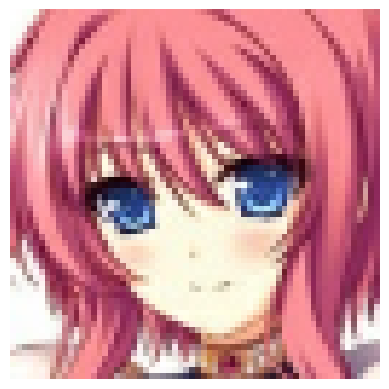

In [73]:
# Obtener un lote de imágenes del dataset de entrenamiento
lote_imagenes = next(iter(imagenes_entrenamiento))
indice_aleatorio = np.random.choice(lote_imagenes.shape[0])
imagen_aleatoria = lote_imagenes[indice_aleatorio].numpy().astype("int32")

# Mostrar la imagen seleccionada
plt.axis("off")
plt.imshow(imagen_aleatoria)
plt.show()

In [70]:
def mostrar(imagenes):
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)  # Crear subgráfico 4x4, posición i+1
        img = keras.utils.array_to_img(imagenes[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

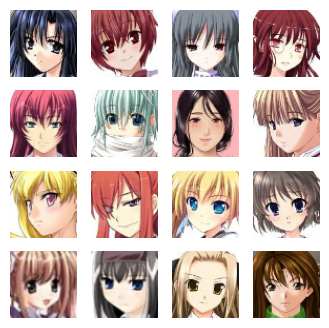

In [74]:
# 16 imagenes del dataset
mostrar(lote_imagenes[:16])

In [75]:
# Normalizar las imágenes al rango [-1, 1] que es el rango de la activación tanh
imagenes_entrenamiento = imagenes_entrenamiento.map(lambda x: (x - 127.5) / 127.5)

## ***Generador***
Define la arquitectura del modelo generador con la API Secuencial de Keras. Usa ReLU excepto para la última capa que tiene tanh como activación. El trabajo del generador es crear imágenes: introducimos ruido aleatorio como entrada al generador e irá amplificandose hasta que el tamaño de imagen deseado sea 64x64x3.

In [76]:
# Dimensión del espacio latente para el ruido aleatorio
DIM_LATENTE = 128

# Inicializador de pesos para el generador DCGAN
PESOS_INI = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Número de canales: 1 para escala de grises, 3 para imágenes a color
CANALES = 3

In [77]:
def construir_generador():
    # Crear modelo secuencial de Keras
    model = Sequential(name="generador")

    # Preparar para reshape: Capas FC => BN => RN
    model.add(layers.Dense(8 * 8 * 512, input_dim=DIM_LATENTE))
    model.add(layers.ReLU())

    # Convertir 1D a 3D: remodelar la salida de la capa anterior
    model.add(layers.Reshape((8, 8, 512)))

    # Upsample a 16x16: aplicar CONV transpuesta => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4),
                                   strides=(2, 2),
                                   padding="same",
                                   use_bias=False,
                                   kernel_initializer=PESOS_INI))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Upsample a 32x32: aplicar CONV transpuesta => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4),
                                   strides=(2, 2),
                                   padding="same",
                                   use_bias=False,
                                   kernel_initializer=PESOS_INI))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Upsample a 64x64: aplicar CONV transpuesta => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4),
                                   strides=(2, 2),
                                   padding="same",
                                   use_bias=False,
                                   kernel_initializer=PESOS_INI))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Capa final: Conv2D con activación tanh
    model.add(layers.Conv2D(CANALES, (4, 4),
                          padding="same",
                          activation="tanh"))

    return model

In [78]:
generador = construir_generador()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
generador.summary()

Model: "generador"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,984,451 (26.64 MB)

 Trainable params: 6,983,555 (26.64 MB)

 Non-trainable params: 896 (3.50 KB)

## ***Crítico***
En WGAN tenemos un crítico en lugar de un discriminador.

In [80]:
# ACTUALIZACIÓN para WGAN: nueva clase que implementa la restricción de recorte de pesos
class WeightClipping(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

    def get_config(self):
        # Configuración para serialización
        return {'clip_value': self.clip_value}

In [81]:
def construir_critico(altura, ancho, profundidad, alpha=0.2):
    # ACTUALIZACIÓN para WGAN: fuerza la restricción 1-Lipschitz con recorte de pesos a [-0.01, 0.01]
    restriccion = WeightClipping(0.01)

    modelo = Sequential(name="critico")
    forma_entrada = (altura, ancho, profundidad)

    # 1. Primer bloque de capas: CONV => LeakyReLU
    modelo.add(layers.Conv2D(64, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint=restriccion,
                            input_shape=forma_entrada))
    modelo.add(layers.LeakyReLU(alpha=alpha))

    # 2. Segundo bloque de capas: CONV => LeakyReLU
    modelo.add(layers.Conv2D(128, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint=restriccion))
    modelo.add(layers.LeakyReLU(alpha=alpha))

    # 3. Tercer bloque de capas: CONV => LeakyReLU
    modelo.add(layers.Conv2D(128, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint=restriccion))
    modelo.add(layers.LeakyReLU(alpha=alpha))

    modelo.add(layers.Flatten())
    modelo.add(layers.Dropout(0.3))

    # ACTUALIZACIÓN para WGAN: activación lineal en la última capa
    # Nota: La capa Dense de Keras ya tiene activación lineal por defecto
    modelo.add(layers.Dense(1, activation="linear"))

    return modelo

In [82]:
critico = construir_critico(64,64,3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [83]:
critico.summary()

Model: "critico"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## ***WGAN-GP***
Subclase keras.Model para implementar WGAN-GP.

In [84]:
class WGAN_GP(keras.Model):
    def __init__(self,
                 critico,
                 generador,
                 dim_latente,
                 pasos_extra_critico,
                 peso_gp=10.0):  # ACTUALIZACIÓN para WGAN-GP: peso de la penalización de gradiente
        super().__init__()
        self.critico = critico
        self.generador = generador
        self.dim_latente = dim_latente
        self.pasos_extra = pasos_extra_critico
        self.peso_gp = peso_gp  # Peso para la penalización de gradiente
        self.metrica_perdida_d = keras.metrics.Mean(name="perdida_d")
        self.metrica_perdida_g = keras.metrics.Mean(name="perdida_g")

    def compile(self, optimizador_d, optimizador_g, fn_perdida_d, fn_perdida_g):
        super(WGAN_GP, self).compile()
        self.optimizador_d = optimizador_d
        self.optimizador_g = optimizador_g
        self.fn_perdida_d = fn_perdida_d
        self.fn_perdida_g = fn_perdida_g

    @property
    def metrics(self):
        return [self.metrica_perdida_d, self.metrica_perdida_g]

    def penalizacion_gradiente(self, tamano_lote, imagenes_reales, imagenes_falsas):
        """Calcula la penalización de gradiente para WGAN-GP.

        La penalización se calcula sobre imágenes interpoladas y se añade
        a la pérdida del crítico para hacer cumplir la condición 1-Lipschitz.
        """
        # 1. valores aleatorios para la interpolación
        alpha = tf.random.normal([tamano_lote, 1, 1, 1], 0.0, 1.0)
        diferencia = imagenes_falsas - imagenes_reales

        # 2. imágenes interpoladas
        imagenes_interpoladas = imagenes_reales + alpha * diferencia

        with tf.GradientTape() as cinta_gp:
            cinta_gp.watch(imagenes_interpoladas)
            # 3. predicciones del crítico para imágenes interpoladas
            pred = self.critico(imagenes_interpoladas, training=True)

        # 4. gradientes respecto a las imágenes interpoladas
        gradientes = cinta_gp.gradient(pred, [imagenes_interpoladas])[0]

        # 5. norma de los gradientes
        norma = tf.sqrt(tf.reduce_sum(tf.square(gradientes), axis=[1, 2, 3]))

        # 6. penalización de gradiente (diferencia respecto a 1)
        penalizacion = tf.reduce_mean((norma - 1.0) ** 2)
        return penalizacion

    def train_step(self, imagenes_reales):
        tamano_lote = tf.shape(imagenes_reales)[0]
        ruido = tf.random.normal(shape=(tamano_lote, self.dim_latente))

        for _ in range(self.pasos_extra):
            with tf.GradientTape() as cinta:
                pred_real = self.critico(imagenes_reales, training=True)
                imagenes_falsas = self.generador(ruido, training=True)
                pred_falso = self.critico(imagenes_falsas, training=True)

                # ACTUALIZACIÓN WGAN-GP: Calcular penalización de gradiente
                gp = self.penalizacion_gradiente(tamano_lote, imagenes_reales, imagenes_falsas)

                # Wasserstein + penalización
                perdida_d = self.fn_perdida_d(pred_real, pred_falso) + gp * self.peso_gp

            gradientes = cinta.gradient(perdida_d, self.critico.trainable_variables)
            self.optimizador_d.apply_gradients(zip(gradientes, self.critico.trainable_variables))

        with tf.GradientTape() as cinta:
            imagenes_falsas = self.generador(ruido, training=True)
            pred_falso = self.critico(imagenes_falsas, training=True)
            perdida_g = self.fn_perdida_g(pred_falso)

        gradientes = cinta.gradient(perdida_g, self.generador.trainable_variables)
        self.optimizador_g.apply_gradients(zip(gradientes, self.generador.trainable_variables))

        self.metrica_perdida_d.update_state(perdida_d)
        self.metrica_perdida_g.update_state(perdida_g)

        return {"perdida_d": self.metrica_perdida_d.result(),
                "perdida_g": self.metrica_perdida_g.result()}

## ***Usar Keras Callback para seguir el entrenamiento***
Lo bueno de overriding train_step() de keras.Model() es que podemos subclasificar Callback para monitorear el entrenamiento DCGAN.

Yo uso el ruido semilla para crear imágenes (con el modelo generador) a lo largo del entrenamiento para ver el progreso que va haciendo el generador. También guardo el modelo generador al final del entrenamiento que potencialmente podría ser utilizado para la inferencia luego.

In [85]:
class MonitorGAN(keras.callbacks.Callback):
    def __init__(self, num_img=3, dim_latente=100):
        self.num_img = num_img          # Número de imágenes a generar
        self.dim_latente = dim_latente  # Dimensión del espacio latente

        self.semilla = tf.random.normal([16, dim_latente])

    def on_epoch_end(self, epoch, logs=None):
        """Callback al final de cada época: genera y guarda imágenes"""
        # Generar imágenes a partir del ruido latente
        imagenes_generadas = self.model.generador(self.semilla)

        # Escalar imágenes de [-1, 1] a [0, 255]
        imagenes_generadas = (imagenes_generadas * 127.5) + 127.5
        imagenes_generadas.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(imagenes_generadas[i])
            plt.imshow(img)
            plt.axis('off')

        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        """Callback al final del entrenamiento: guarda el generador"""
        self.model.generador.save('generador.h5')

## ***Compilar y entrenar WGAN-GP***

In [86]:
# modelo WGAN-GP (Wasserstein GAN con penalización de gradiente)
wgan_gp = WGAN_GP(
    critico=critico,
    generador=generador,
    dim_latente=DIM_LATENTE,
    pasos_extra_critico=5,
    peso_gp=10.0
)

## Pérdida de Wasserstein

In [87]:
def perdida_d_wasserstein(pred_real, pred_falso):
    perdida_real = tf.reduce_mean(pred_real)      # Promedio predicciones reales
    perdida_falsa = tf.reduce_mean(pred_falso)    # Promedio predicciones falsas
    return perdida_falsa - perdida_real           # Diferencia crítica para WGAN


def perdida_g_wasserstein(pred_falso):
    return -tf.reduce_mean(pred_falso)  # Negativo porque queremos maximizar la calidad

In [88]:
TAZA_APRENDIZAJE = 0.0002  # Paper WGAN-GP recomienda 0.0002 como tasa de aprendizaje óptima

optimizador_d = keras.optimizers.Adam(
    learning_rate=TAZA_APRENDIZAJE,
    beta_1=0.5,
    beta_2=0.9   # Momentum a corto plazo
)  # usar Adam en lugar de RMSProp

optimizador_g = keras.optimizers.Adam(
    learning_rate=TAZA_APRENDIZAJE,
    beta_1=0.5,
    beta_2=0.9
)

In [89]:
wgan_gp.compile(
    optimizador_d=optimizador_d,
    optimizador_g=optimizador_g,
    fn_perdida_d=perdida_d_wasserstein,
    fn_perdida_g=perdida_g_wasserstein
)

##***Entrenar WGAN-GP***

Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - perdida_d: -20.4046 - perdida_g: -39.8443

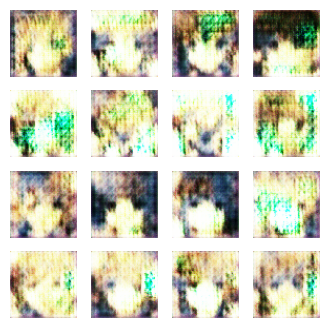

249/249 ━━━━━━━━━━━━━━━━━━━━ 259s 911ms/step - perdida_d: -20.4078 - perdida_g: -39.9201
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - perdida_d: -13.8135 - perdida_g: -62.9187

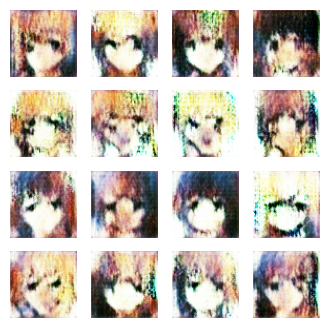

249/249 ━━━━━━━━━━━━━━━━━━━━ 223s 834ms/step - perdida_d: -13.8101 - perdida_g: -62.9229
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - perdida_d: -10.1874 - perdida_g: -66.9307

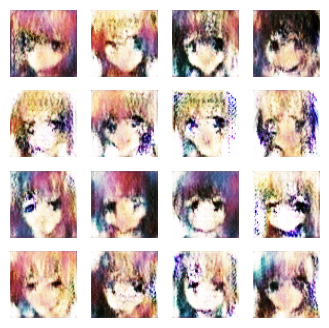

249/249 ━━━━━━━━━━━━━━━━━━━━ 262s 835ms/step - perdida_d: -10.1854 - perdida_g: -66.9175
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - perdida_d: -8.5441 - perdida_g: -62.1721

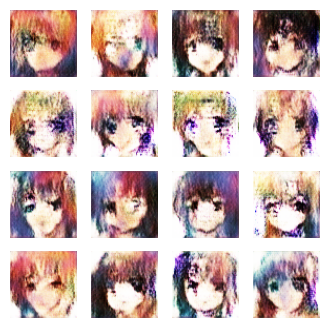

249/249 ━━━━━━━━━━━━━━━━━━━━ 262s 836ms/step - perdida_d: -8.5431 - perdida_g: -62.1696
Epoch 5/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - perdida_d: -7.3737 - perdida_g: -67.1279

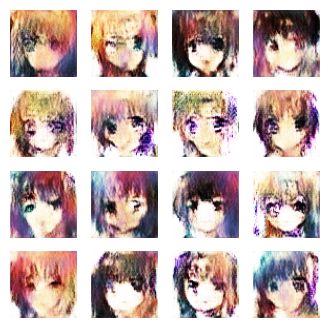

249/249 ━━━━━━━━━━━━━━━━━━━━ 208s 835ms/step - perdida_d: -7.3727 - perdida_g: -67.0992


In [90]:
wgan_gp.fit(
    imagenes_entrenamiento,  # Dataset de imágenes (normalizadas en [-1, 1])
    epochs=5,       # Iteraciones completas sobre el dataset
    callbacks=[MonitorGAN(num_img=16, dim_latente=DIM_LATENTE)]  # Callback de visualización
)